In [2]:
# install commands for modules that might not be present in the target machine
!pip install contractions
!pip install autocorrect
!pip install scikit-plot

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 3.6MB 13.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for autocorrect ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bf/b8/ae/704d5643f1d0637c5b87d9feccf2ee923c492b703bb0bfbb19
Successfully built autocorrect
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 276kB 15.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# import required modules
# pre-processing
import nltk
nltk.download('stopwords')
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score

# baseline model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

# neural network model building
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# metrics 
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

# core
import pandas as pd, numpy as np
import string
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [4]:
# read train and test data from file
# Pre-conditions: train.csv, test.csv, test_labels.csv are present in the source directory
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
true_labels = pd.read_csv('test_labels.csv')


Correlation matrix of data


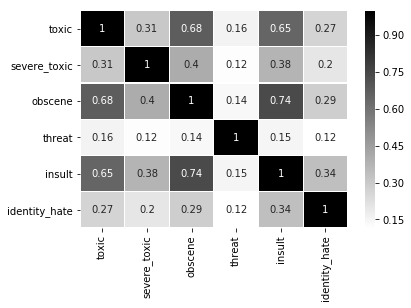

In [5]:
# Data Visualization 1- Correlation matrix
print("\nCorrelation matrix of data")
sns.heatmap(train.corr(),annot = True,cmap = 'gray_r',linewidths=0.2) 
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.xticks(rotation=90)
plt.show()

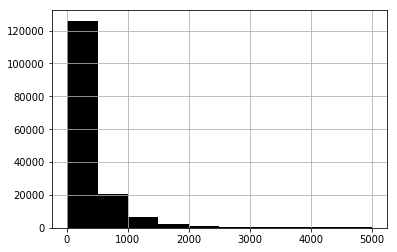

In [6]:
# Data Visualizatio 2- Histogram of text lengths
lengths = train.comment_text.str.len()
lengths.hist(color = 'black')


In [7]:
# Extract class names and train & test comments into different variables
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_train = train['comment_text']
X_test = test['comment_text']

# replace null values
X_train.fillna("unknown", inplace=True)
X_test.fillna("unknown", inplace=True)


In [8]:
# Comment Pre-processing
# function to perform pre-processing steps on comment text and return the clean comments
def cleanComments(data):
    # convert to lowercase
    data = data.apply(lambda x:x.lower())
    # remove \n
    data = data.apply(lambda x:re.sub("\\n","",x))
    # remove ip address
    data = data.apply(lambda x:re.sub(
    "\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x))
    # remove user names
    data = data.apply(lambda x:re.sub("\[\[.*\]","",x))
    # expand contractions
    data = data.apply(lambda x:contractions.fix(x))
    # remove stop words
    stop_words = stopwords.words('english')
    data = data.apply(lambda x: ' '.join([
        word for word in x.split() if word not in (stop_words)]))
    # remove punctuations
    data = data.apply(lambda x: re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','',x))
 
    return data


In [9]:
# pre-process train and test comments
X_train = cleanComments(X_train)
X_test = cleanComments(X_test)

In [10]:
# make a copy of the clean text and work on it.
X_train2 = X_train.copy()
X_test2 = X_test.copy()

In [11]:
# vectorize train and test comments
# word 1-grams, limit the feature space to top 10000 features
word_vectorizer = TfidfVectorizer(sublinear_tf = True,strip_accents = 'unicode', analyzer = 'word',
    token_pattern = r'\w{1,}', ngram_range = (1, 1), max_features = 10000)

# fit the vectorizer on training text
word_vectorizer.fit(X_train2)

# transform training and test comments into feature vectors
w_train_features = word_vectorizer.transform(X_train2)
w_test_features = word_vectorizer.transform(X_test2)

In [12]:
# vectorize train and test comments
# char 2-grams, limit the feature space to top 50000 features
char_vectorizer = TfidfVectorizer(sublinear_tf = True, strip_accents = 'unicode', analyzer = 'char',
    stop_words = 'english', ngram_range = (2, 6), max_features = 50000)

# fit the vectorizer on training text
char_vectorizer.fit(X_train2)

# transform training and test comments into feature vectors
c_train_features = char_vectorizer.transform(X_train2)
c_test_features = char_vectorizer.transform(X_test2)

In [13]:
# now stack the word and character feature vectors to use all features
from scipy.sparse import hstack
train_features = hstack([w_train_features,c_train_features])
test_features = hstack([w_test_features,c_test_features])

In [14]:
# check the total number of featues generated
train_features.shape, test_features.shape

((159571, 60000), (153164, 60000))

In [15]:
# function to fit different models and return the prediction results
def modelFitting(model):
    # create a predictions dataframe
    predictions = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
    predictions['id'] = test['id']
    probabilities = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
    probabilities['id'] = test['id']
    # for each class apply the model and predict probabilities
    for classname in class_names:
        train_class = train[classname]
        
        # fit the model on train features
        model.fit(train_features, train_class)
        
        # make predictions on test features
        predictions[classname] = model.predict_proba(test_features)[:,1]
        probabilities[classname] = predictions[classname]
        
    # thresholding to classify per class as 1 or 0
    for col in class_names:
        predictions.loc[predictions[col] > 0.5, col] = 1
        predictions.loc[predictions[col] < 0.5, col] = 0
        
        # convert to integer values
        predictions[col] = predictions[col].apply(lambda x: int(x))
    
    # rows having -1 values are not used for scoring, so drop the rows
    true_labels.drop(true_labels.loc[true_labels['toxic']==-1].index, inplace=True)

    # remove corresponding rows in the predictions dataframe
    predictions = predictions[predictions.id.isin(true_labels.id)]
    probabilities = probabilities[probabilities.id.isin(true_labels.id)]
    
    return [probabilities,predictions]
    

In [16]:
# function to calculate AUC (Area under curve) value for individual classes
def calculateAUC(true_labels,pred_labels):
    fpr, tpr, thresh = metrics.roc_curve(true_labels, pred_labels)
    auc = metrics.auc(fpr,tpr)
    
    # plot the ROC curve for each class
    plt.figure(figsize=(6,4))
    plt.plot([0,1],[0,1],color='black')
    plt.plot(fpr,tpr,color='blue',label= 'AUC = %.2f'%auc)
    plt.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characteristic')
    return auc

... Processing toxic
Test accuracy is 0.9345243677514146
Test precision and recall is (0.9415934618060139, 0.9345243677514146, 0.9373231300448318, None)
... Processing severe_toxic
Test accuracy is 0.9931382662790335
Test precision and recall is (0.9928266823274472, 0.9931382662790335, 0.9929776458402081, None)
... Processing obscene
Test accuracy is 0.9677389102503986
Test precision and recall is (0.9665568269882593, 0.9677389102503986, 0.9670596973074521, None)
... Processing threat
Test accuracy is 0.9967332520553941
Test precision and recall is (0.9959621009838181, 0.9967332520553941, 0.9962206169391, None)
... Processing insult
Test accuracy is 0.9660508299728031
Test precision and recall is (0.9631694070965591, 0.9660508299728031, 0.9640157561141377, None)
... Processing identity_hate
Test accuracy is 0.9910594266779206
Test precision and recall is (0.9894444959482248, 0.9910594266779206, 0.9896800314788513, None)
Logistic Regression AUC: 0.9783856210288701


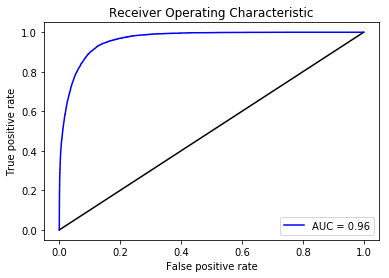

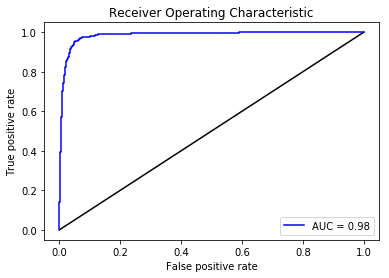

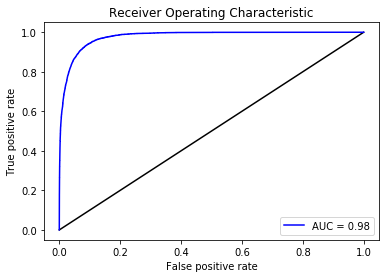

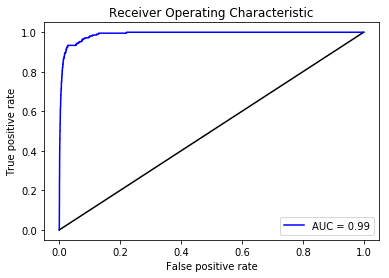

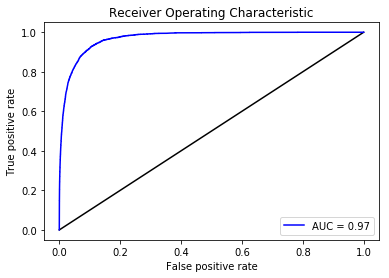

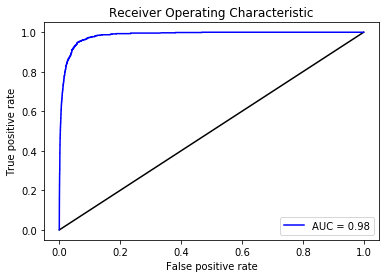

In [17]:
# Logistic Regression
# define the model
LR_model=LogisticRegression(solver='sag')

# method call to fit model and make predictions
LR_probabilities,LR_predictions=modelFitting(LR_model)

auc_list = []
# print results for each class
for classname in class_names:
        print('... Processing {}'.format(classname))
        print('Test accuracy is {}'.format(accuracy_score(true_labels[classname], LR_predictions[classname])))
       
        print('Test precision and recall is {}'.format(precision_recall_fscore_support(true_labels[classname], LR_predictions[classname], 
                                    average='weighted')))
        auc = calculateAUC(true_labels[classname],LR_probabilities[classname])
        auc_list.append(auc)
print("Logistic Regression AUC:", np.mean(auc_list))

... Processing toxic
Test accuracy is 0.8938385069867767
Test precision and recall is (0.9324298856104033, 0.8938385069867767, 0.9065617232923656, None)
... Processing severe_toxic
Test accuracy is 0.9751320766513489
Test precision and recall is (0.9939363262100327, 0.9751320766513489, 0.9832164772762949, None)
... Processing obscene
Test accuracy is 0.9306011441432993
Test precision and recall is (0.9573244230402632, 0.9306011441432993, 0.9400404747645491, None)
... Processing threat
Test accuracy is 0.9952639969989684
Test precision and recall is (0.9944684038156375, 0.9952639969989684, 0.9948496115999323, None)
... Processing insult
Test accuracy is 0.9266935509081247
Test precision and recall is (0.9565586307188089, 0.9266935509081247, 0.9375449678279593, None)
... Processing identity_hate
Test accuracy is 0.9780080652724374
Test precision and recall is (0.9875002018681919, 0.9780080652724374, 0.9820291553256729, None)
Multinomial NB AUC: 0.9538051078551413


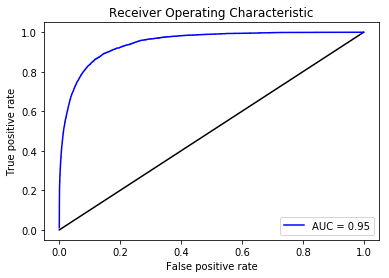

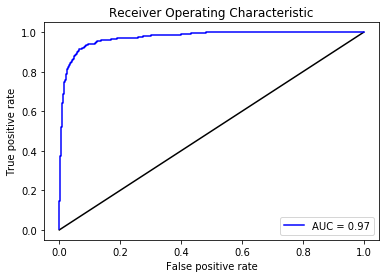

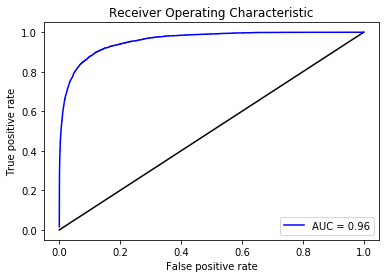

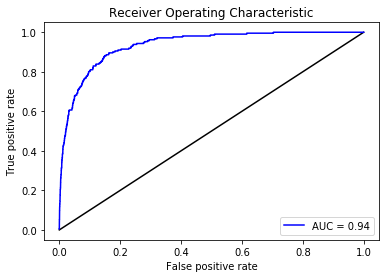

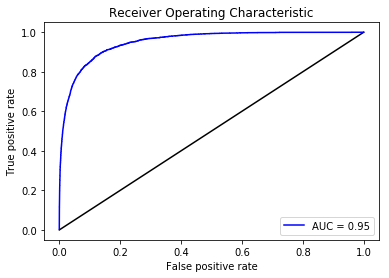

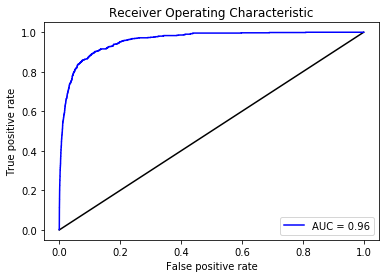

In [18]:
# Multinomial Naive Bayes
# define the model
NB_model=MultinomialNB(fit_prior=True, class_prior=None)

# method call to fit model and make predictions
NB_probabilities,NB_predictions=modelFitting(NB_model)

auc_list = []
# print results for each class
for classname in class_names:
        print('... Processing {}'.format(classname))
        print('Test accuracy is {}'.format(accuracy_score(true_labels[classname], NB_predictions[classname])))
        print('Test precision and recall is {}'.format(precision_recall_fscore_support(true_labels[classname], NB_predictions[classname], 
                                    average='weighted')))
        auc = calculateAUC(true_labels[classname],NB_probabilities[classname])
        auc_list.append(auc)
print("Multinomial NB AUC:", np.mean(auc_list))

... Processing toxic
Test accuracy is 0.9323361155397167
Test precision and recall is (0.936147145962201, 0.9323361155397167, 0.934010515149382, None)
... Processing severe_toxic
Test accuracy is 0.993575916721373
Test precision and recall is (0.9905099006276665, 0.993575916721373, 0.9917026939692668, None)
... Processing obscene
Test accuracy is 0.9593610303541843
Test precision and recall is (0.9597686265439226, 0.9593610303541843, 0.9595603327954504, None)
... Processing threat
Test accuracy is 0.9967957735471569
Test precision and recall is (0.9958528281132789, 0.9967957735471569, 0.9954219547790807, None)
... Processing insult
Test accuracy is 0.9581731220106912
Test precision and recall is (0.955805363495293, 0.9581731220106912, 0.9568340284949258, None)
... Processing identity_hate
Test accuracy is 0.9907624495920473
Test precision and recall is (0.989260406206561, 0.9907624495920473, 0.9881801869955708, None)
Random Forest AUC: 0.8996577652160269


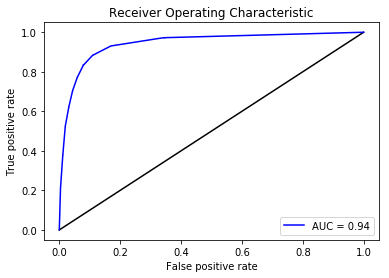

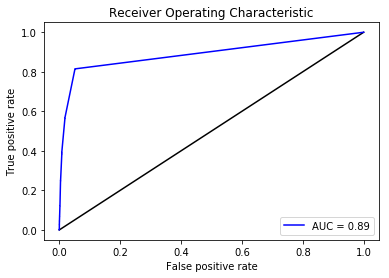

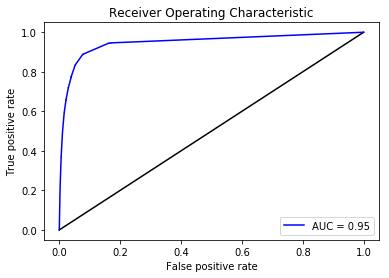

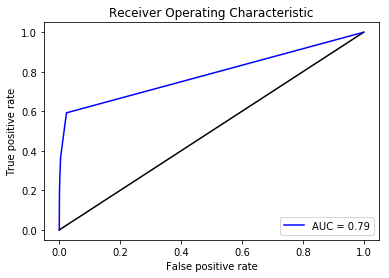

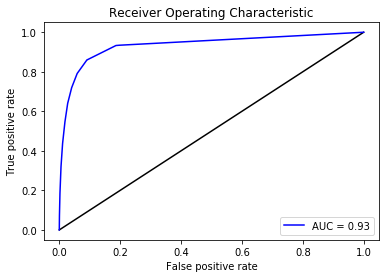

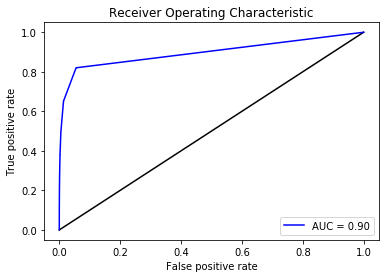

In [20]:
# Random forest classifier
# define the model
RFC_model=RandomForestClassifier(n_estimators=10)

# method call to fit model and make predictions
RFC_probabilities,RFC_predictions=modelFitting(RFC_model)

auc_list = []
# print results for each class
for classname in class_names:
        print('... Processing {}'.format(classname))
        print('Test accuracy is {}'.format(accuracy_score(true_labels[classname], RFC_predictions[classname])))
        print('Test precision and recall is {}'.format(precision_recall_fscore_support(true_labels[classname], RFC_predictions[classname], 
                                    average='weighted')))
        auc = calculateAUC(true_labels[classname],RFC_probabilities[classname])
        auc_list.append(auc)
print("Random Forest AUC:", np.mean(auc_list))

In [21]:
# Neural network model
# set parameters for feature vector creation
embed_size = 50 
max_features = 20000
maxlength = 100

In [22]:
# get the required data 
y = train[class_names].values
train_sentences = X_train
test_sentences = X_test

In [23]:
# use the Keras Tokenizer to generate features from training and test dataset
tok = Tokenizer(num_words= max_features)
tok.fit_on_texts(list(train_sentences))

#convert text to word sequences for the embedding layer
tokenized_train = tok.texts_to_sequences(train_sentences)
tokenized_test = tok.texts_to_sequences(test_sentences)

# pad sequences to account for the variable length text sequences
D_train = pad_sequences(tokenized_train, maxlen = maxlength)
D_test = pad_sequences(tokenized_test,maxlen= maxlength)

In [24]:
# extract the pretrained word embeddings (GLoVe twitter data) and extract the word vectors
embeddings_index = dict()
f = open('glove.twitter.27B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [25]:
# get the word index from tokenizer
word_index = tok.word_index

# make the vocabulary size as whichever is least: max_features or the word index length
vocab_size = min(max_features, len(word_index))

# initialize embedding_matrix with zeros
embedding_matrix = np.zeros((vocab_size, 50))

# loop through the features and construct the embedding matrix with the features and glove embeddings
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [26]:
# define the neural network layers
# input layer with input shape
inp = Input(shape=(maxlength,))

# embedding layer with the pre-trained word embeddings
layer = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)

# bidirectional LSTM layer to learn from previous and future representations
layer = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(layer)

# maxpool layer to reduce input dimensionality to prevent over-fitting and reduce complexity
layer = GlobalMaxPool1D()(layer)

# dense hidden layer with 50 neurons
layer = Dense(50, activation="relu")(layer)

# dropout layer to prevent over-fitting
layer = Dropout(0.1)(layer)

# dense hidden layer with 6 neurons
layer = Dense(6, activation="sigmoid")(layer)

# build and compile the model
model = Model(inputs=inp, outputs=layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# fit model on training data
history = model.fit(D_train, y, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 4129s 29ms/step - loss: 0.0438 - acc: 0.9834 - val_loss: 0.0486 - val_acc: 0.9824
Epoch 2/2
143613/143613 [==============================] - 4187s 29ms/step - loss: 0.0403 - acc: 0.9844 - val_loss: 0.0487 - val_acc: 0.9823


In [29]:
# predict labels for test data
y_test = model.predict([D_test], batch_size=1024, verbose=1)

153164/153164 [==============================] - 197s 1ms/step


In [30]:
# copy the predicted probabilities
LSTM_predictions = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
LSTM_probabilities = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
LSTM_predictions['id']=test['id']
LSTM_probabilities['id'] = test['id']
LSTM_predictions['toxic'] = y_test[:,0]
LSTM_predictions['severe_toxic'] = y_test[:,1]
LSTM_predictions['obscene'] = y_test[:,2]
LSTM_predictions['threat'] = y_test[:,3]
LSTM_predictions['insult'] = y_test[:,4]
LSTM_predictions['identity_hate'] = y_test[:,5]

# copy probabilities to LSTM_probabilities for AUC calculation
LSTM_probabilities['toxic'] = y_test[:,0]
LSTM_probabilities['severe_toxic'] = y_test[:,1]
LSTM_probabilities['obscene'] = y_test[:,2]
LSTM_probabilities['threat'] = y_test[:,3]
LSTM_probabilities['insult'] = y_test[:,4]
LSTM_probabilities['identity_hate'] = y_test[:,5]

In [32]:
# thresholding to classify per class as 1 or 0
for col in class_names:
    LSTM_predictions[col] = np.where(LSTM_predictions[col]>0.5, 1, 0)
    
# remove rows that are not in true_labels dataframe    
LSTM_predictions = LSTM_predictions[LSTM_predictions.id.isin(true_labels.id)]
LSTM_probabilities = LSTM_probabilities[LSTM_probabilities.id.isin(true_labels.id)]

... Processing toxic
Test accuracy is 0.9217230923129826
Test precision and recall is (0.9410089765740113, 0.9217230923129826, 0.9282962675788858, None)
... Processing severe_toxic
Test accuracy is 0.9941542405201789
Test precision and recall is (0.992623757175941, 0.9941542405201789, 0.9931377404597541, None)
... Processing obscene
Test accuracy is 0.9585638813342087
Test precision and recall is (0.9652305637795826, 0.9585638813342087, 0.9611085933158553, None)
... Processing threat
Test accuracy is 0.9964987964612836
Test precision and recall is (0.9955329703340151, 0.9964987964612836, 0.9958831057387655, None)
... Processing insult
Test accuracy is 0.9642533370846228
Test precision and recall is (0.964506538213919, 0.9642533370846228, 0.9643778184428291, None)
... Processing identity_hate
Test accuracy is 0.9916377504767264
Test precision and recall is (0.9903670402451917, 0.9916377504767264, 0.9906100448601428, None)
Bidirectional LSTM AUC: 0.9762196417659398


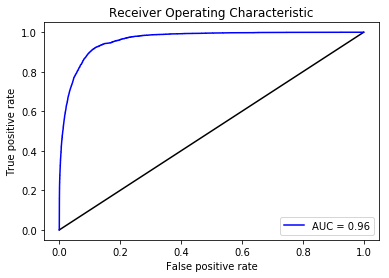

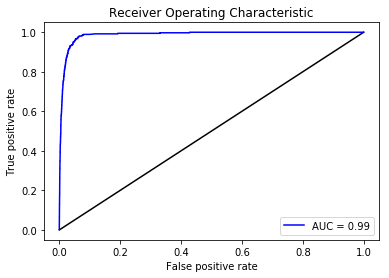

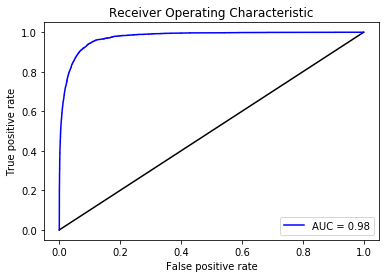

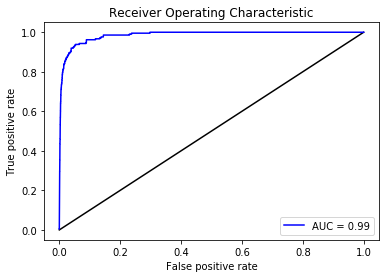

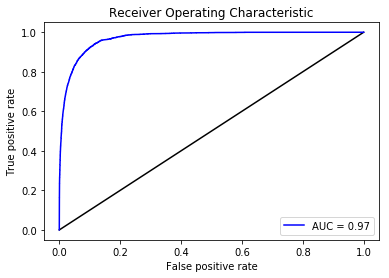

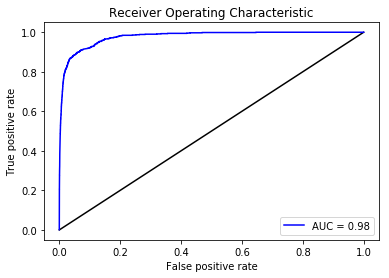

In [33]:
# print results for each class
auc_list = []
for classname in class_names:
        print('... Processing {}'.format(classname))
        print('Test accuracy is {}'.format(accuracy_score(true_labels[classname], LSTM_predictions[classname])))
       
        print('Test precision and recall is {}'.format(precision_recall_fscore_support(true_labels[classname], LSTM_predictions[classname], 
                                    average='weighted')))
        auc = calculateAUC(true_labels[classname],LSTM_probabilities[classname])
        auc_list.append(auc)
print("Bidirectional LSTM AUC:", np.mean(auc_list))